# Using Machine Learning to Correct the Performance of the MERRA-2 Model against GPM Observations

## A case study of rainfall in the WASHINGTON, DC area.

Five (5) machine learning algorithms were tested. These were;

1. Random Forest Regression
2. Gradient Boosting Regression
3. Lasso Regression
4. Elastic Net Regression
5. K-Nearest Neighbors Regression
    

MERRA-2 is Modern-Era Retrospective analysis for Research and Applications version 2. The data are available at https://disc.gsfc.nasa.gov/datasets/M2TMNXFLX_5.12.4/summary

GPM is the Global Precipitation Measurement, multisatellite precipitation product. The data are available at https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGM_06/summary.


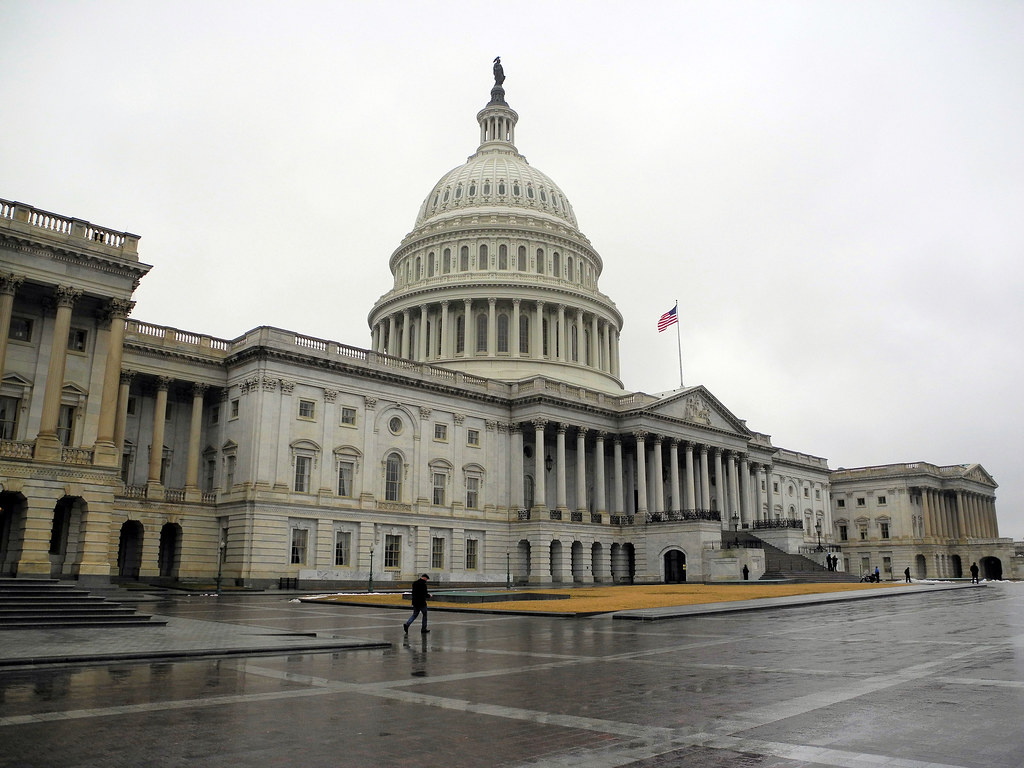
Photo credit:mbell1975

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
warnings.filterwarnings('ignore')

In [2]:
# Import data

df1 = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\washington_rainfall\merra_2_model.csv')
df2 = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\washington_rainfall\gpm_obs.csv')

print(df1.head())
print('==='*10)
print(df2.head())

         time     merra
0  2000-06-01  1.691687
1  2000-07-01  2.935857
2  2000-08-01  4.252675
3  2000-09-01  5.362448
4  2000-10-01  0.164280
         time       gpm
0  2000-06-01  4.798028
1  2000-07-01  4.924958
2  2000-08-01  3.476404
3  2000-09-01  4.885356
4  2000-10-01  0.223071


## Data Preparation

In [3]:
# Check for missing data

print(df1.isnull().sum())
print('==='*10)
print(df2.isnull().sum())


# Check data information
print('==='*15)
print(df1.info())
print('==='*15)
print(df2.info())

time     0
merra    0
dtype: int64
time    0
gpm     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    256 non-null    object 
 1   merra   256 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    256 non-null    object 
 1   gpm     256 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB
None


In [4]:
# Join both datasets into one dataframe

df = df1.merge(df2, how='inner', on='time')
print(df.info())
print('==='*20)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    256 non-null    object 
 1   merra   256 non-null    float64
 2   gpm     256 non-null    float64
dtypes: float64(2), object(1)
memory usage: 8.0+ KB
None
         time     merra       gpm
0  2000-06-01  1.691687  4.798028
1  2000-07-01  2.935857  4.924958
2  2000-08-01  4.252675  3.476404
3  2000-09-01  5.362448  4.885356
4  2000-10-01  0.164280  0.223071


## Exloratory Data Analysis

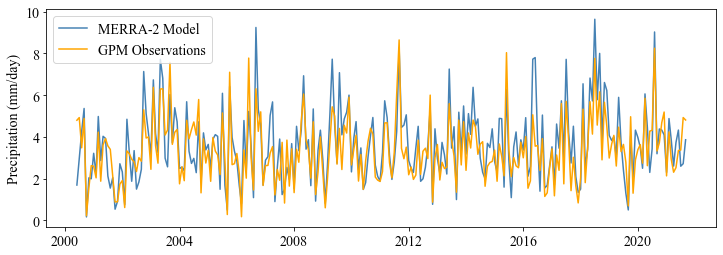

In [5]:
# Make general plot

fig, ax = plt.subplots(figsize=(12,4))
plt.plot(pd.to_datetime(df['time']), 'merra', data=df, label='MERRA-2 Model', color='steelblue')
plt.plot(pd.to_datetime(df['time']), 'gpm', data=df, label='GPM Observations', color='orange')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()

In [6]:
# Get Correlation

df.corr()

,merra,gpm
merra,1.000000,0.819378
gpm,0.819378,1.000000


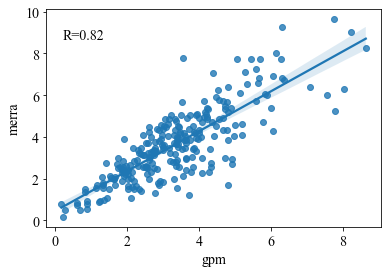

In [7]:
sns.regplot(data=df, x='gpm', y='merra')
plt.text(0.2, 8.7, 'R=0.82')
plt.show()

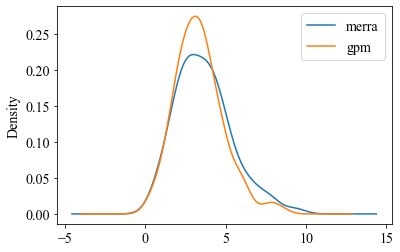

In [8]:
# Plot distribution

df.plot.kde()
plt.show()

## Data Preprocessing

In [9]:
# Manually select training and testing data so as to keep track of time selection

train = df[pd.to_datetime(df['time']) <= '2015-12-01']
test = df[pd.to_datetime(df['time']) > '2015-12-01']

print(train.tail())
print('==='*20)
print(test.head())

           time     merra       gpm
182  2015-08-01  1.088057  2.098613
183  2015-09-01  3.518697  3.012941
184  2015-10-01  4.236868  2.613869
185  2015-11-01  2.610588  2.519728
186  2015-12-01  3.859405  3.745358
           time     merra       gpm
187  2016-01-01  3.368157  2.997472
188  2016-02-01  4.921340  4.014542
189  2016-03-01  2.115081  1.539288
190  2016-04-01  2.580609  1.893459
191  2016-05-01  7.726651  5.059494


In [10]:
# Select the variables

X_train = train['merra']
X_test = test['merra']

y_train = train['gpm']
y_test = test['gpm']

In [11]:
# Scale the data

scaler = preprocessing.MinMaxScaler()

x_train = scaler.fit_transform(np.asarray(X_train).reshape(-1, 1), y_train) # The data was reshaped because its 1-dimensional data
x_test = scaler.fit_transform(np.asarray(X_test).reshape(-1, 1), y_test)

## Perform regression

In [12]:
# Using Random Forest
rf = RandomForestRegressor()
rf_reg = rf.fit(x_train, y_train)
rf_pred = rf_reg.predict(x_test)

# Using Gradient Boosting
gb = GradientBoostingRegressor()
gb_reg = gb.fit(x_train, y_train)
gb_pred = gb_reg.predict(x_test)

# Using Lasso regression
lsr = Lasso()
lsr_reg = lsr.fit(x_train, y_train)
lsr_pred = lsr_reg.predict(x_test)

# Using Elsatic Net
en = ElasticNet()
en_reg = en.fit(x_train, y_train)
en_pred = en_reg.predict(x_test)

# Using K nearest neighbors
knn = KNeighborsRegressor(n_neighbors=20)
knn_reg = knn.fit(x_train, y_train)
knn_pred = knn_reg.predict(x_test)

## Perform Evaluation

In [13]:
# Make evaluation function

def evaluation(y_test, y_pred):
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R^2', r2_score(y_test, y_pred))
    print('Corr', np.corrcoef(y_test, y_pred)[0, 1])

In [14]:
print('MERRA-2')
evaluation(y_test, X_test)
print('---'*10)

print('Random Forest')
evaluation(y_test, rf_pred)
print('---'*10)

print('Gradient Boosting')
evaluation(y_test, gb_pred)
print('---'*10)

print('Lasso')
evaluation(y_test, lsr_pred)
print('---'*10)

print('Elastic Net')
evaluation(y_test, en_pred)
print('---'*10)

print('KNN')
evaluation(y_test, knn_pred)
print('--- END ---')

MERRA-2
MAE 0.9264473557971016
RMSE 1.1705086899201507
R^2 0.42527995029076415
Corr 0.8400845177948502
------------------------------
Random Forest
MAE 0.7991585665940572
RMSE 1.029140597798389
R^2 0.5557202845222493
Corr 0.7744185171390094
------------------------------
Gradient Boosting
MAE 0.7390824980655107
RMSE 0.9504131921538401
R^2 0.6210935698582296
Corr 0.8009382932404355
------------------------------
Lasso
MAE 1.2083952990238704
RMSE 1.558315862284697
R^2 -0.018633715136105344
Corr 7.086366071640079e-17
------------------------------
Elastic Net
MAE 1.2083952990238704
RMSE 1.558315862284697
R^2 -0.018633715136105344
Corr 7.086366071640079e-17
------------------------------
KNN
MAE 0.7117948558021739
RMSE 0.9349118680735775
R^2 0.6333527690023611
Corr 0.8035991364494386
--- END ---


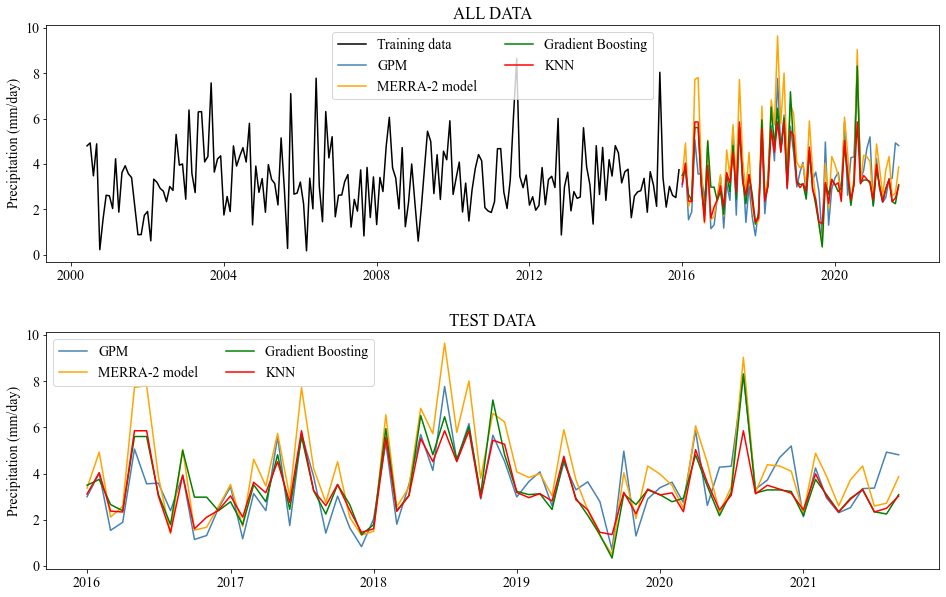

In [15]:
# Plot the predictions of the 2 best models, that is, Random Forest and K-Nearest Neighbors

fig, ax = plt.subplots(figsize=(16,10))
plt.gcf().subplots_adjust(hspace=0.3)

plt.subplot(2,1,1)
plt.plot(pd.to_datetime(train['time']), train['gpm'], color='black', label='Training data')
plt.plot(pd.to_datetime(test['time']), test['gpm'], label='GPM', color='steelblue')
plt.plot(pd.to_datetime(test['time']), test['merra'], label='MERRA-2 model', color='orange')
plt.plot(pd.to_datetime(test['time']), gb_pred, label='Gradient Boosting', color='green')
plt.plot(pd.to_datetime(test['time']), knn_pred, label='KNN', color='red')
plt.legend(ncol=2)
plt.ylabel('Precipitation (mm/day)')
plt.title('ALL DATA')

plt.subplot(2,1,2)
plt.plot(pd.to_datetime(test['time']), test['gpm'], label='GPM', color='steelblue')
plt.plot(pd.to_datetime(test['time']), test['merra'], label='MERRA-2 model', color='orange')
plt.plot(pd.to_datetime(test['time']), gb_pred, label='Gradient Boosting', color='green')
plt.plot(pd.to_datetime(test['time']), knn_pred, label='KNN', color='red')
plt.legend(ncol=2)
plt.ylabel('Precipitation (mm/day)')
plt.title('TEST DATA')
plt.show()

In [16]:
# The machine learning models seem to out perform the default MERRA-2 model in all metrics except correlation.
# The plot above seemingly shows that after 2019, the prediction of the machine learning models becomes more distant from the
# observations.
# I will do a test to confirm this.

# Check the number of rows up until the end of 2019
print('Number of rows up to Dec 2019 is', test[test['time'] <= '2019-12-01'].shape[0])

Number of rows up to Dec 2019 is 48


In [19]:
# Perform second evaluation based only on this data of 48 entries

print('MERRA-2')
evaluation(X_test.iloc[0:48], y_test.iloc[0:48])
print('---'*10)
print('Gradient Boosting')
evaluation(y_test.iloc[0:48], gb_pred[0:48])
print('---'*10)
print('KNN model')
evaluation(y_test.iloc[0:48], knn_pred[0:48])
print('---'*10)

MERRA-2
MAE 0.9756082922916667
RMSE 1.2359247890122422
R^2 0.6546926022592072
Corr 0.8952513951037402
------------------------------
Gradient Boosting
MAE 0.7069647895368366
RMSE 0.8705500430072813
R^2 0.6941493834384491
Corr 0.8474212862804891
------------------------------
KNN model
MAE 0.6355701556322916
RMSE 0.8019613519232694
R^2 0.7404453843695132
Corr 0.8615640290308849
------------------------------


In [20]:
# Plot this performance

df_performance = pd.DataFrame({'Model':['MERRA-2', 'Gradient Boosting', 'K-Nearest Neighbors'],
                              'MAE_all_data':[mean_absolute_error(y_test, x_test), mean_absolute_error(y_test, gb_pred),
                                              mean_absolute_error(y_test, knn_pred)],
                              'MAE_upto_2019':[mean_absolute_error(X_test.iloc[0:48], y_test.iloc[0:48]),
                                              mean_absolute_error(y_test.iloc[0:48], gb_pred[0:48]),
                                              mean_absolute_error(y_test.iloc[0:48], knn_pred[0:48])],
                               'RMSE_all_data':[(np.sqrt(mean_squared_error(X_test, y_test))),
                                              (np.sqrt(mean_squared_error(y_test, gb_pred))),
                                              (np.sqrt(mean_squared_error(y_test, knn_pred)))],
                              'RMSE_upto_2019':[(np.sqrt(mean_squared_error(X_test.iloc[0:48], y_test.iloc[0:48]))),
                                              (np.sqrt(mean_squared_error(y_test.iloc[0:48], gb_pred[0:48]))),
                                              (np.sqrt(mean_squared_error(y_test.iloc[0:48], knn_pred[0:48])))],
                              'Correlation_all_data':[(np.corrcoef(y_test, X_test)[0, 1]),
                                                     (np.corrcoef(y_test, gb_pred)[0, 1]),
                                                     (np.corrcoef(y_test, knn_pred)[0, 1])],
                              'Correlation_upto_2019':[(np.corrcoef(X_test.iloc[0:48], y_test.iloc[0:48])[0, 1]),
                                                     (np.corrcoef(y_test.iloc[0:48], gb_pred[0:48])[0, 1]),
                                                     (np.corrcoef(y_test.iloc[0:48], knn_pred[0:48])[0, 1])]})
df_performance

,Model,MAE_all_data,MAE_upto_2019,RMSE_all_data,RMSE_upto_2019,Correlation_all_data,Correlation_upto_2019
0,MERRA-2,3.121184,0.975608,1.170509,1.235925,0.840085,0.895251
1,Gradient Boosting,0.739082,0.706965,0.950413,0.870550,0.800938,0.847421
2,K-Nearest Neighbors,0.711795,0.635570,0.934912,0.801961,0.803599,0.861564


## Conclusions

### This work was intended to improve the estimates of the MERRA-2 model and make them much closer to the GPM observations. However, MERRA-2 was already estimating GPM observations quite well. The correlation was 0.82 based on all the data. This work tested 5 machine learning algorithms to check if they could improve the MERRA-2 performance any futher.

### The results show that of all the 5 algorithms, only 3 of them improved on MERRA-2 estimates. These were Random Forest, Gradient Boosting and K-Nearest Neighbors. However, these models only improved the mean absolute error, the root mean square error and the coefficient of determination but did not improve the correlation.

### The predictions of the machine learning models seemed closest to the observations for the period 2016 to 2019. However, even when the correlation was tested for only this period, they still didn't make any improvement to it.

### Overall, the K-Nearest Neighbors algorithm was the best in performance.